# MOwNiT
## Laboratorium 1 - Arytmetyka komputerowa

Kalkulatory IEEE-754:
* http://babbage.cs.qc.cuny.edu/IEEE-754/
* https://www.h-schmidt.net/FloatConverter/IEEE754.html

In [1]:
# znak, cecha, mantysa
# uwaga - w Julii tablice indeksujemy od 1
# uwaga: ukryta jedynka nie jest pamiętana
# uwaga: cecha jest pamiętana w kodzie z nadmiarem (tutaj BIAS=127)
decode(x::Float32) = (b=bitstring(x); (b[1], b[2:9], b[10:32]))

decode (generic function with 1 method)

In [2]:
decode(Float32(1.1))

('0', "01111111", "00011001100110011001101")

## Trochę teorii o IEEE-754

Liczby zmienno przecinkowe są zapisywane w standardzie jako:

$L = (-1)^{znak} * mantysa * 2^{cecha}$ 

* znak - 0 oznacza liczbę dodatnią, 1 ujemną
* mantysa - wpływa na precyzje
* cecha - wpływa na zakres, składająca się z samych 0 albo 1 ma specjalne znaczenie

| Nazwa     | Liczba bitów | Bity znaku | Bity cechy | Bity mantysy | Bias  | Dokładność (cyfry znaczące) | Uwagi                                 |
|-----------|--------------|------------|------------|--------------|-------|-----------------------------|---------------------------------------|
| half      | 16           | 1          | 5          | 10           | 15    | 4                           |                                       |
| single    | 32           | 1          | 8          | 23           | 127   | 7                           |                                       |
| double    | 64           | 1          | 11         | 52           | 1023  | 16                          |                                       |
| quadruple | 128          | 1          | 15         | 112          | 16383 | 34                          | Wprowadzone w 2008, niezbyt popularne |

### Liczby znormalizowane

Mantysa ma wartość z przedziału [1,2) - pierwszy bit ma zawsze wartość 1, więc nie trzeba go zapisywać (jest on tam "domyślnie")
$L = (-1)^{znak} * 1.mantysa * 2^{cecha-bias}$

In [2]:
decode(Float32(2.5))

('0', "10000000", "01000000000000000000000")

Policzenie wartości na podstawie reprezentacji bitowej.

In [3]:
cecha = 2^7-127
mantysa = 2^-2 + 1
cecha, mantysa

(1, 1.25)

In [4]:
L = 1 * mantysa * 2^cecha

2.5

### Liczba 0

Wartości 0 nie da się zapisać w postaci znormalizowanej. Jeżeli zarówno mantysa jak i cecha zawierają same 0, to reprezentowana jest wartość 0.

Ze względu na bit znaku, istnieją dwie możliwości 0: +0 oraz -0.

In [5]:
decode(Float32(-0.0))

('1', "00000000", "00000000000000000000000")

In [6]:
decode(Float32(+0.0))

('0', "00000000", "00000000000000000000000")

In [7]:
Float32(-0.0) == Float32(+0.0) # Oba zera są równe

true

### Liczby zdenormalizowane

Jeżeli cecha składa się z samych 0 to liczba jest *zdenormalizowana* i mantysa nie posiada "domyślnego" bitu. Pozwala to na reprezentacje liczb bliskich 0, które bez denormalizacji byłyby 0.

$L = (-1)^{znak} * 0.mantysa * 2^{-bias+1}$

Uwaga: Liczba 0 nie jest określana jako zdenormalizowana, pomimo, że cecha ma same 0!

In [8]:
L = Float32(1e-42)
decode(Float32(L)), issubnormal(L)

(('0', "00000000", "00000000000001011001010"), true)

### Wartości specjalne

####  Nieskończoność

Reprezentowana jest przez cechę z samych 1 oraz mantysę z samych 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

In [9]:
decode(Inf32)

('0', "11111111", "00000000000000000000000")

In [10]:
decode(-Inf32)

('1', "11111111", "00000000000000000000000")

#### NaN

Reprezentowana jest przez cechę z samych 1 oraz mantysę różną od 0.

`NaN`ami są np. 0/0, $\infty - \infty$

In [11]:
Float32(0)/Float32(0)

NaN32

In [12]:
Inf32 - Inf32

NaN32

In [13]:
decode(NaN32)

('0', "11111111", "10000000000000000000000")

### Praktyczne wskazówki

Kolejność działań ma znaczenie:

In [14]:
e = eps(Float32)/2

5.9604645f-8

In [15]:
(Float32(1.0) + e) + e

1.0f0

In [16]:
Float32(1.0) + (e + e)

1.0000001f0

Wniosek: Sumujemy od najmniejszych

Nie powinno się porównywać floatów bezpośrednio. Większość języków posiada funkcje do porówywania liczb zmiennoprzecinkowych z tolerancją, np. `isapprox` w Julii, `numpy.isclose` w Pythonie etc.

In [17]:
0.1 + 0.2 == 0.3

false

In [18]:
isapprox(0.1 + 0.2, 0.3)

true

## Przykłady

In [2]:
bitstring(Float32(.1))

"00111101110011001100110011001101"

In [20]:
bitstring(Float32(1.0))

"00111111100000000000000000000000"

In [21]:
bitstring(Float64(1.0))

"0011111111110000000000000000000000000000000000000000000000000000"

In [22]:
# domyślnie Float64
bitstring(1.0)

"0011111111110000000000000000000000000000000000000000000000000000"

In [23]:
# Float16
bitstring(Float16(1.0))

"0011110000000000"

In [24]:
println(significand(Float32(1.2)), "*2^", exponent(Float32(1.20)))

1.2*2^0


In [25]:
# co ile liczby sa reprezentowane 
c=Float32[]
a=Float32(1.0)
r=1:10
for i=r
    push!(c, a)
    a=nextfloat(a)
end
map(x-> bitstring(x),c)

10-element Vector{String}:
 "00111111100000000000000000000000"
 "00111111100000000000000000000001"
 "00111111100000000000000000000010"
 "00111111100000000000000000000011"
 "00111111100000000000000000000100"
 "00111111100000000000000000000101"
 "00111111100000000000000000000110"
 "00111111100000000000000000000111"
 "00111111100000000000000000001000"
 "00111111100000000000000000001001"

In [26]:
# Maszynowe epsilon mówi, jaki jest odstęp między kolejnymi liczbami zmiennoprzecinkowymi reprezentowanymi w komputerze
eps(Float32(1))

1.1920929f-7

In [27]:
eps(Float32(2))

2.3841858f-7

In [28]:
# Badanie postaci zdenormalizowanej. Co się dzieje, jak liczby są coraz mniejsze?
a = Float32(1e-33)
while a > 0
    a = a/Float32(2.0)
    println(a, decode(a), "  ", issubnormal(a))
end

5.0e-34('0', "00010000", "01001100010011101001100")  false
2.5e-34('0', "00001111", "01001100010011101001100")  false
1.25e-34('0', "00001110", "01001100010011101001100")  false
6.25e-35('0', "00001101", "01001100010011101001100")  false
3.125e-35('0', "00001100", "01001100010011101001100")  false
1.5625e-35('0', "00001011", "01001100010011101001100")  false
7.8125e-36('0', "00001010", "01001100010011101001100")  false
3.90625e-36('0', "00001001", "01001100010011101001100")  false
1.953125e-36('0', "00001000", "01001100010011101001100")  false
9.765625e-37('0', "00000111", "01001100010011101001100")  false
4.8828126e-37('0', "00000110", "01001100010011101001100")  false
2.4414063e-37('0', "00000101", "01001100010011101001100")  false
1.2207032e-37('0', "00000100", "01001100010011101001100")  false
6.103516e-38('0', "00000011", "01001100010011101001100")  false
3.051758e-38('0', "00000010", "01001100010011101001100")  false
1.525879e-38('0', "00000001", "01001100010011101001100")  false

In [1]:
# Rysowanie wykresów
using Pkg
Pkg.add("Plots")
# http://docs.juliaplots.org/latest/tutorial/
using Plots

    Updating registry at `C:\Users\danie\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\danie\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\danie\.julia\environments\v1.7\Manifest.toml`


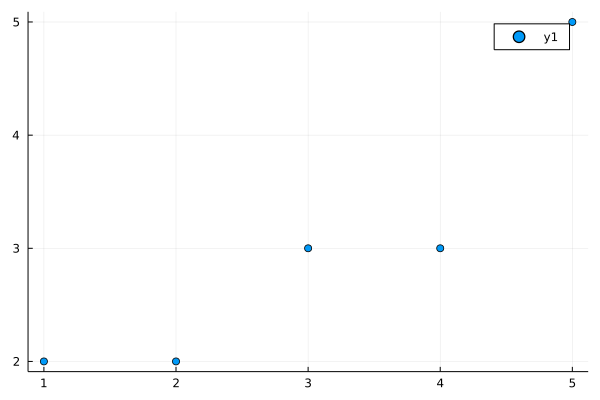

In [2]:
scatter(1:1:5, [2,2,3,3,5])

## Bonus

Ciekawe zastosowanie znajomości IEEE-754 do obliczania odwrotności pierwiastka, wykorzystane w grze Quake 3: [filmik](https://youtu.be/p8u_k2LIZyo)

# Zadania

### Zadanie 1

Porównać w języku Julia reprezentację bitową liczby 1/3 dla `Float16`, `Float32`, `Float64` oraz liczby, 
która jest inicjalizowana jako `Float16`, a potem rzutowana na `Float64`.

In [17]:
decode(x::Float16) = (b=bitstring(x); (b[1], b[2:6], b[7:16]))
decode(x::Float32) = (b=bitstring(x); (b[1], b[2:9], b[10:32]))
decode(x::Float64) = (b=bitstring(x); (b[1], b[2:12], b[13:64]))

decode (generic function with 3 methods)

In [10]:
decode(Float16(1/3))

('0', "01101", "0101010101")

In [11]:
decode(Float32(1/3))

('0', "01111101", "01010101010101010101011")

In [18]:
decode(Float64(1/3))

('0', "01111111101", "0101010101010101010101010101010101010101010101010101")

In [21]:
x = Float16(1/3)
y = Float64(x)
decode(y)

('0', "01111111101", "0101010101000000000000000000000000000000000000000000")

### Zadanie 2

Zbadać, jak zmienia się odległość między kolejnymi liczbami zminnoprzecinkowymi 
reprezentowanymi w komputerze za pomocą języka Julia. 
Narysować wykres używając Plots zależności odległości od wartości liczby dla zakresu  od 1.0 do 1000000.0.

In [6]:
scatter(Float32(1.0) : Float32(1000.0) : Float32(1000000.0), map((x) -> eps(Float32(x)), 1:1000:1000000))

LoadError: UndefVarError: scatter not defined

### Zadanie 3

Jedną z bibliotek numerycznych, jaką będziemy używać na zajęciach jest <a href="http://home.agh.edu.pl/~kzajac/dydakt/mownit/lab1/gsl.html">GSL</a> (język C). Korzystając ze <a href="https://www.gnu.org/software/gsl/doc/html/ieee754.html"> wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych</a> zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

Kod załączyć jako komórka Markdown sformatowana jako C ([link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#code)). Wynik także jako Markdown (kod albo fragment zrzutu ekranu).

```C
#include <stdio.h>
#include <gsl/gsl_ieee_utils.h>

int main (void){
  float f = 0.00000000000000000000000001;
  while(f > 0){
    gsl_ieee_printf_float(&f);
    printf ("\n");
    f=f/2.0;
  }
  return 0;
}
```

WYNIKI:

```
 1.10001100001001000000110*2^-119
 1.10001100001001000000110*2^-120
 1.10001100001001000000110*2^-121
 1.10001100001001000000110*2^-122
 1.10001100001001000000110*2^-123
 1.10001100001001000000110*2^-124
 1.10001100001001000000110*2^-125
 1.10001100001001000000110*2^-126
 0.11000110000100100000011*2^-126
 0.01100011000010010000010*2^-126
 0.00110001100001001000001*2^-126
 0.00011000110000100100000*2^-126
 0.00001100011000010010000*2^-126
 0.00000110001100001001000*2^-126
 0.00000011000110000100100*2^-126
 0.00000001100011000010010*2^-126
 0.00000000110001100001001*2^-126
 ```

### Zadanie 4

Na przykładzie wybranego algorytmu niestabilnego numerycznie: 
1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Wszystkie punkty przedstawić w postaci notatnika Julii.

Przykładem algorytmu niestabilnego numerycznie jest algorytm przybliżania wartości wyrażenia e^x za pomocą poniższego wzoru:

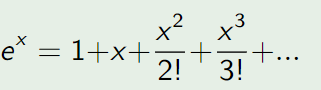

Daje on złe wyniki dla ujemnych x ze względu na cancellation (odejmowanie bliskich liczb). Dla x =-5.5 poprawny wynik, to 0.00408677. 

In [11]:
x = Float32(-5.5)
e = Float32(1.0)
for i=1:20
    e = e + (x^i / factorial(i))
end
e

0.0041464055f0

Wersję stabilną tego algorytmu możemy uzyskać za pomocą następującego przekształcenia:

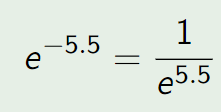

Dzięki niemu unikniemy odejmowaniu bliskich liczb.

In [12]:
x = Float32(-5.5)
e = Float32(1.0)
if x >= 0.0
    for i=1:20
        e = e + (x^i / factorial(i))
    end
else
    x = -x
    for i=1:20
        e = e + (x^i / factorial(i))
    end
    e = 1/e
end
e

0.004086773f0